# fastText Commit Classification

In this notebook, we use a pre-trained fastText classification learned from labeled datasets to classify unlabeled commits gathered from Github.

#### Import the required libraries

In [2]:
import pandas as pd
from fasttext import load_model

#### Read the data

In [3]:
classifier = load_model("../model/model.bin") 
df = pd.read_csv('../data/commits.csv',  lineterminator='\n', encoding="utf-8")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#### Format the data

In [4]:
# replace \n with space
df = df.replace('\n','', regex=True)

In [5]:
# check the shape of the Github data
df.shape

(50000, 1)

In [6]:
df.columns

Index(['message'], dtype='object')

##### Normalize the data

In [7]:
# convert the commit message column into string
commits = list(df['message'].astype(str))

##### Predict using fastText 

In [8]:
# predict the label with fastText
labels = classifier.predict(commits)  

In [9]:
res = list(zip(*labels))
res_list = [x[0] for x in res]
lst2 = [item[0] for item in res_list]
df['labels_predicted'] = lst2

##### Check the predictions made

In [10]:
df

,message,labels_predicted
0,Use github's new relative path format.,__label__features
1,Fix conditional variance of LS estimate.In 18....,__label__corrective
2,Merge pull request #8 from cortex/masterShared...,__label__nonfunctional
3,Integrate Mathieu Bryen's pull request.,__label__perfective
4,Merge branch 'master' of github.com:mavam/stat...,__label__features
...,...,...
49995,10.6 build fix,__label__corrective
49996,Don't delete beanstalkd.spec during distclean.,__label__perfective
49997,Re-add bitcoin(32&80).xpm,__label__perfective
49998,fixed some ClassInfo bugsSummary:for better re...,__label__corrective


In [11]:
classifier.predict(['fixed some ClassInfo bugsSummary:for better re.'])  

([['__label__corrective']], [array([0.9992285], dtype=float32)])

In [12]:
import fasttext
model = fasttext.train_supervised(input="../data/commits.train", lr=0.1, epoch=25, wordNgrams=2)
stats = model.test("../data/commits.valid")
model.predict(['fixed some ClassInfo bugsSummary:for better re.'])  

Read 0M words
Number of words:  11972
Number of labels: 5
Progress: 100.0% words/sec/thread:  691999 lr:  0.000000 avg.loss:  0.204855 ETA:   0h 0m 0s


([['__label__corrective']], [array([0.99983835], dtype=float32)])

In [13]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test("../data/commits.valid"))

N	2269
P@1	0.784
R@1	0.784


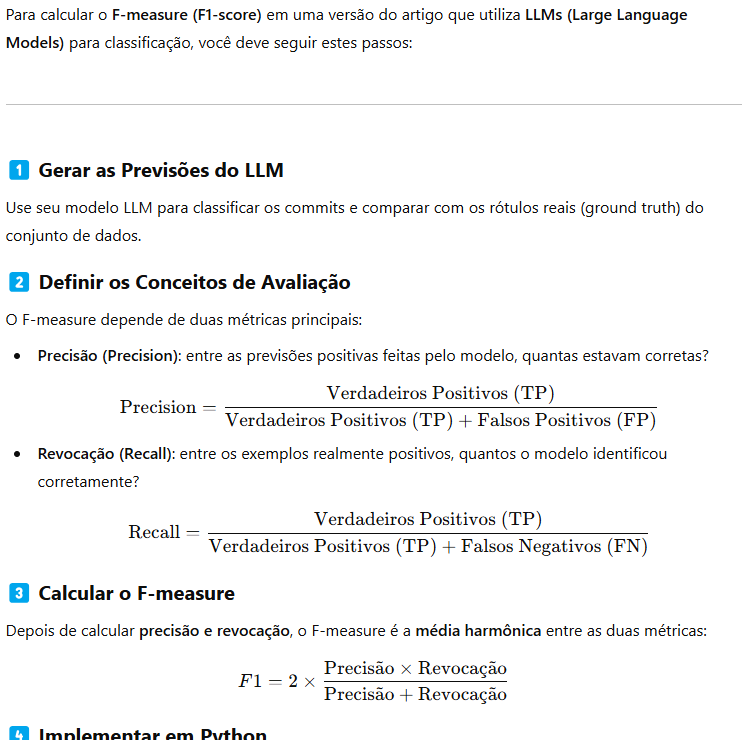

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Suponha que você tenha os rótulos verdadeiros e as previsões do LLM
y_true = ["corrective", "features", "corrective", "perfective", "non-functional"]
y_pred = ["corrective", "features", "perfective", "perfective", "corrective"]

# Calcula as métricas
precision = precision_score(y_true, y_pred, average="macro")  # Média das classes
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

/home/matheus/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.50
Recall: 0.62
F1-score: 0.54


In [15]:
import pandas as pd

# Definir o nome do arquivo
arquivo = "../data/commits.valid" 

# Ler o arquivo corretamente com separação entre rótulo e comentário
def process_line(line):
    parts = line.split(' ', 1)  # Separar apenas no primeiro espaço
    #label = parts[0].replace('__label__', '')
    label = parts[0]
    comment = parts[1] if len(parts) > 1 else ''
    return label, comment

# Ler o arquivo e armazenar em um DataFrame
with open(arquivo, "r", encoding="utf-8") as f:
    data = [process_line(line.strip()) for line in f]

df = pd.DataFrame(data, columns=['label', 'comment'])

# Exibir as primeiras linhas do DataFrame
print(df.head())


                    label                                            comment
0        __label__unknown  infra .  chart: fix socket info items duplicat...
1  __label__nonfunctional  performance improvements to get the existing f...
2       __label__features  enable action item text display on pre-android...
3  __label__nonfunctional  issue 55 enhanced integration tests to support...
4        __label__unknown  add a simple duplicate method to maintain cons...


In [16]:
import pandas as pd

# Definir o nome do arquivo
arquivo = "../data/commits-labeled.txt" 

# Ler o arquivo corretamente com separação entre rótulo e comentário
def process_line(line):
    if line.startswith("__label__"):  # Considerar apenas linhas que iniciam com __label__
        parts = line.split(' ', 1)  # Separar apenas no primeiro espaço
        label = parts[0]
        comment = parts[1] if len(parts) > 1 else ''
        return label, comment
    return None  # Ignorar linhas que não começam com __label__

# Ler o arquivo e armazenar em um DataFrame
with open(arquivo, "r", encoding="utf-8") as f:
    data = []
    current_label = None
    current_comment = ""
    
    for line in f:
        line = line.strip()
        if line.startswith("__label__"):  # Nova entrada encontrada
            if current_label is not None:
                data.append((current_label, current_comment))
            label, comment = process_line(line)
            if label is not None:
                current_label = label
                current_comment = comment
        else:
            current_comment += " " + line  # Continuar acumulando a descrição
    
    if current_label is not None:
        data.append((current_label, current_comment))  # Adicionar o último registro

df = pd.DataFrame(data, columns=['label', 'comment'])

# Exibir as primeiras linhas do DataFrame
print(df.head())


                 label                                            comment
0  __label__perfective        Add marble diagrams for Single operators.--
1  __label__perfective              Change hasException to hasThrowable--
2    __label__features  Trying to extend the Scheduler interface accor...
3    __label__features   RunAsync method for outputting multiple values--
4  __label__corrective  forEach with Action1 but not Observer--I re-re...


In [17]:
commits = list(df['comment'].astype(str))
#labels = classifier.predict(commits)
labels = model.predict(commits)
res = list(zip(*labels))
res_list = [x[0] for x in res]
lst2 = [item[0] for item in res_list]
df['label_predicted'] = lst2
df.head()

,label,comment,label_predicted
0,__label__perfective,Add marble diagrams for Single operators.--,__label__perfective
1,__label__perfective,Change hasException to hasThrowable--,__label__features
2,__label__features,Trying to extend the Scheduler interface accor...,__label__features
3,__label__features,RunAsync method for outputting multiple values--,__label__features
4,__label__corrective,forEach with Action1 but not Observer--I re-re...,__label__corrective


In [18]:
df_filtered = df[df['label'] != df['label_predicted']]
df_filtered

,label,comment,label_predicted
1,__label__perfective,Change hasException to hasThrowable--,__label__features
8,__label__corrective,1.x: Fix Completable swallows- OnErrorNotImple...,__label__features
11,__label__corrective,Fixed byLine test to use line.separator system...,__label__perfective
34,__label__perfective,Perf Tests with JMH--,__label__features
37,__label__perfective,Remove Unnecessary Subscription--- be explicit...,__label__corrective
...,...,...,...
4387,__label__perfective,Project Structure dialog. Some forms refactored.,__label__features
4458,__label__perfective,"""Small API change that affects a ton of classe...",__label__corrective
4471,__label__perfective,"""Started moving to the type system. Design is ...",__label__features
4509,__label__perfective,Updated Quadtree data structure with performan...,__label__nonfunctional


In [19]:
df_corrective = df[df['label_predicted'] == '__label__corrective']
df_corrective

,label,comment,label_predicted
4,__label__corrective,forEach with Action1 but not Observer--I re-re...,__label__corrective
7,__label__corrective,Trying to fix non-deterministic test--- not su...,__label__corrective
9,__label__corrective,Fix unit test after last() changed behavior--,__label__corrective
17,__label__corrective,"""Wraps DoOnEach in a SafeObserver--This commit...",__label__corrective
25,__label__corrective,TakeWhile protect calls to predicate--,__label__corrective
...,...,...,...
4056,__label__corrective,new UI - corresponding UI change after bug 695...,__label__corrective
4073,__label__corrective,[ALLUXIO-1909] Fix failing tests,__label__corrective
4079,__label__corrective,Fix failing integration tests,__label__corrective
4080,__label__corrective,new UI - domain page - fix a bug that is cause...,__label__corrective


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Suponha que você tenha os rótulos verdadeiros e as previsões do LLM
y_true = df['label']
y_pred = df['label_predicted']

# Calcula as métricas
precision = precision_score(y_true, y_pred, average="macro")  # Média das classes
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precision: 0.91
Recall: 0.90
F1-score: 0.90


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

                        precision    recall  f1-score   support

   __label__corrective       0.97      0.87      0.92      1592
     __label__features       0.84      0.93      0.88       799
__label__nonfunctional       0.99      0.89      0.94      1006
   __label__perfective       0.76      0.93      0.84       849
      __label__unknown       0.98      0.90      0.94       282

              accuracy                           0.90      4528
             macro avg       0.91      0.90      0.90      4528
          weighted avg       0.91      0.90      0.90      4528



In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Exemplo de mensagens
mensagens = [
    "O sistema apresentou falha ao carregar os dados",
    "Erro ao conectar no servidor",
    "A interface do software é intuitiva e fácil de usar",
    "O aplicativo trava com frequência",
    "A experiência do usuário foi ótima, sem bugs",
]

# 1. Vetorização do texto (Bag-of-Words)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_corrective['comment'])

# 2. Aplicar LDA
num_topicos = 10
lda_model = LatentDirichletAllocation(n_components=num_topicos, random_state=42)
lda_model.fit(X)

# 3. Exibir palavras-chave dos tópicos
termos = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda_model.components_):
    palavras_importantes = [termos[j] for j in topic.argsort()[-10:]]
    print(f"Tópico {i}: {', '.join(palavras_importantes)}")

Tópico 0: value, java, fixes, added, code, fixed, step, problem, bug, fix
Tópico 1: zone, domain, ip, add, cloudstack, new, page, ui, bug, fix
Tópico 2: errors, error, wrong, cloudstack, object, bug, smallfix, issue, fix, fixed
Tópico 3: page, api, vm, network, fixed, error, ui, bug, cloudstack, fix
Tópico 4: commit, cases, bug, alluxio, cloudstack, tests, fixed, failing, test, fix
Tópico 5: check, working, account, vm, autoscale, fixed, ha, work, fix, bug
Tópico 6: issue, resolve, behavior, error, placeholders, code, hudson, bug, kt, fixed
Tópico 7: asf, apache, trunk, repos, 0310, git, org, https, id, svn
Tópico 8: hudson, test, storage, problem, exception, bug, cloudstack, error, fixed, fix
Tópico 9: fixes, related, change, issue, error, cloudstack, added, fix, bug, fixed


In [23]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
import gensim
import numpy as np
from gensim import corpora
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Pré-processamento
stop_words = set(stopwords.words('english'))
mensagens_processadas = [
    [word for word in word_tokenize(m.lower()) if word.isalpha() and word not in stop_words] 
    for m in df_corrective['comment']
]

# Criar dicionário e corpus
dicionario = corpora.Dictionary(mensagens_processadas)
corpus = [dicionario.doc2bow(texto) for texto in mensagens_processadas]

# Testar diferentes números de tópicos
def calcular_coerencia(num_topicos):
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topicos, id2word=dicionario, passes=10)
    coherence_model = CoherenceModel(model=lda_model, texts=mensagens_processadas, dictionary=dicionario, coherence='c_v')
    return coherence_model.get_coherence()

# Testar para diferentes valores de K
topicos_testados = list(range(2, 10))  # Testa de 2 a 10 tópicos
coherencias = [calcular_coerencia(k) for k in topicos_testados]

# Encontrar o melhor K
melhor_k = topicos_testados[np.argmax(coherencias)]
print(f"Melhor número de tópicos: {melhor_k}")


Melhor número de tópicos: 9


In [34]:
import pandas as pd
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Exemplo de mensagens
mensagens = [
    "O sistema apresentou falha ao carregar os dados",
    "Erro ao conectar no servidor",
    "A interface do software é intuitiva e fácil de usar",
    "O aplicativo trava com frequência",
    "A experiência do usuário foi ótima, sem bugs",
]

# 1. Pré-processamento
stop_words = set(stopwords.words('english'))
mensagens_processadas = [[word for word in word_tokenize(m.lower()) if word.isalpha() and word not in stop_words] for m in df_corrective['comment']]

# 2. Criar o dicionário e a matriz BoW
dicionario = corpora.Dictionary(mensagens_processadas)
corpus = [dicionario.doc2bow(texto) for texto in mensagens_processadas]

# 3. Aplicar LDA
num_topicos = melhor_k
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topicos, id2word=dicionario, passes=10)

# 4. Exibir os tópicos
for i, topic in lda_model.show_topics(formatted=False, num_words=10):
    print(f"Tópico {i}: {topic}")
    sentence = ""
    for w in topic:
        sentence += w[0]+" "
    print(f"{sentence}")


Tópico 0: [('fixed', 0.033433877), ('fix', 0.02265779), ('bug', 0.014783648), ('https', 0.0145687675), ('build', 0.013155198), ('due', 0.011578727), ('api', 0.010013142), ('issue', 0.00969816), ('added', 0.008185745), ('failed', 0.0080162985)]
fixed fix bug https build due api issue added failed 
Tópico 1: [('fix', 0.040300637), ('bug', 0.029682502), ('add', 0.017075187), ('page', 0.014883137), ('storage', 0.013632855), ('template', 0.013536325), ('host', 0.011908498), ('ui', 0.0104788635), ('primary', 0.009592745), ('button', 0.008930989)]
fix bug add page storage template host ui primary button 
Tópico 2: [('bug', 0.085462645), ('fix', 0.07881989), ('ui', 0.05049038), ('new', 0.024673099), ('cloudstack', 0.02335968), ('page', 0.022748249), ('error', 0.018260278), ('api', 0.016771346), ('network', 0.010065513), ('fixed', 0.00939274)]
bug fix ui new cloudstack page error api network fixed 
Tópico 3: [('bug', 0.035878982), ('fix', 0.033318195), ('fixed', 0.01607781), ('fixes', 0.0154490